# Python notebook for post-processing apical responses.
# Frequency analysis of results data.
Assumes folder directory structure:
<pre><code>  IMAGING
    image_stacks
    notebooks
    results
</code></pre>
Execute the code sequentially, one block at a time, using &lt;shift-return&gt;.

In [1]:
import glob
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fftpack import fft, fftfreq
from scipy.linalg import dft
from scipy.interpolate import interp1d
from scipy.io.wavfile import write
from scipy import signal


#### Select a results directory, one or more regions and set analysis frame range.


In [2]:
%matplotlib widget

# global variables
results_sel = ""  # the selected results directory
stim_start = 100  # analysis start frame
stim_done = 250   # analysis end frame

s = {'description_width':'200px'} # a default widget style

# create results directory widget
result_dirs = sorted([f.split('/')[-2] for f in glob.glob("../results/*/", recursive=False)], key=str.casefold)
results_widget = widgets.Select(options=result_dirs, description='Results dir', 
                            disabled=False, layout=widgets.Layout(width='400px'))
# create numeric input widgets
stim_start_widget = widgets.BoundedIntText(value=stim_start, min=0, max=1000, step=1,
                    description='Stimulation start frame', disabled=False, layout={'width':'270px'}, style=s)
stim_done_widget = widgets.BoundedIntText(value=stim_done, min=0, max=1000, step=1,
                    description='Stimulation done frame', disabled=False, layout={'width':'270px'}, style=s)

# create status widget
status_widget = widgets.HTML(value=' ', description=' ')

# display and respond to the widgets
def f(w1, w2, w3, w4):
  global results_sel
  global stim_start, stim_done
  results_sel = results_widget.value
  stim_start = stim_start_widget.value
  stim_done = stim_done_widget.value

  if not results_sel:
    status_widget.value = "No result directory selected."
  else:
    status_widget.value = "Selection OK."
display(widgets.interactive(f, w1=results_widget, w2=status_widget,
                           w3=stim_start_widget, w4=stim_done_widget))

interactive(children=(Select(description='Results dir', layout=Layout(width='400px'), options=('20200701-20144…

#### Frequency analysis over all regions using a filter bank.

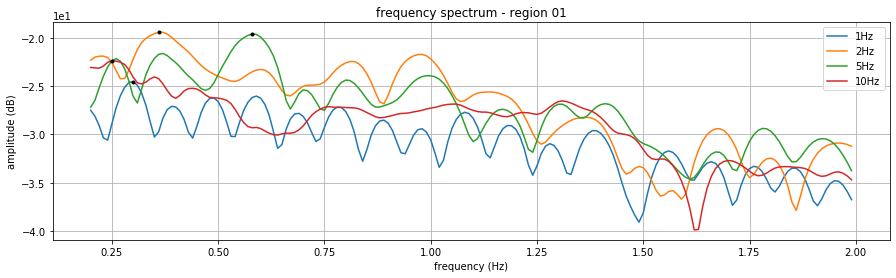

dominant frequencies:  ['0.3Hz', '0.36Hz', '0.58Hz', '0.25Hz']


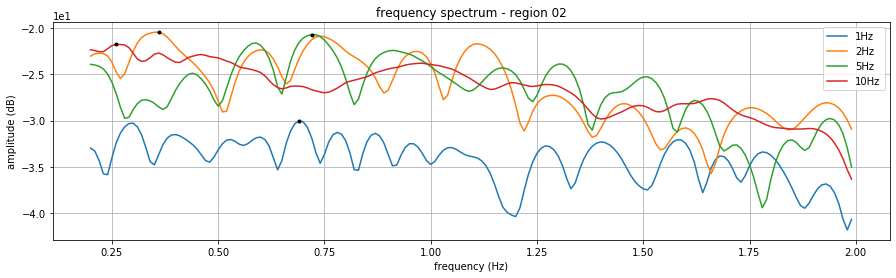

dominant frequencies:  ['0.69Hz', '0.36Hz', '0.72Hz', '0.26Hz']


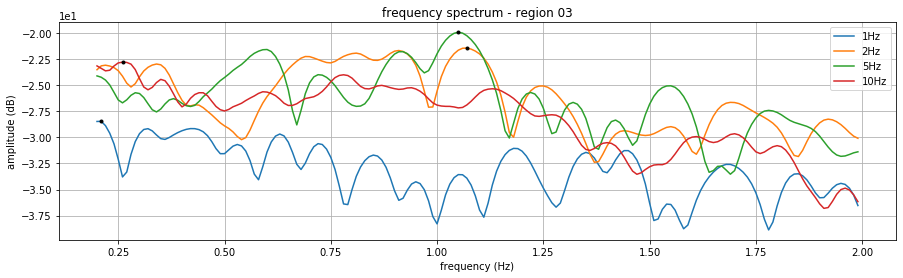

dominant frequencies:  ['0.21Hz', '1.07Hz', '1.05Hz', '0.26Hz']


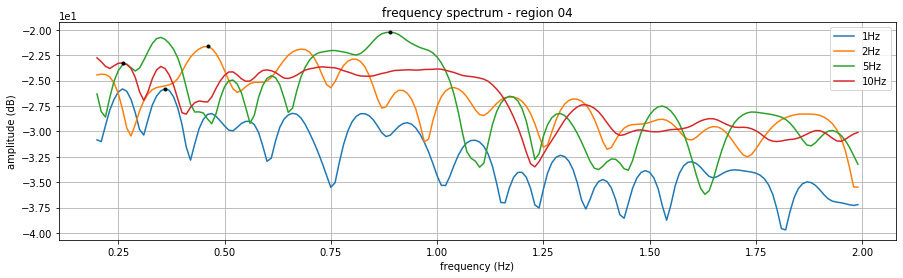

dominant frequencies:  ['0.36Hz', '0.46Hz', '0.89Hz', '0.26Hz']


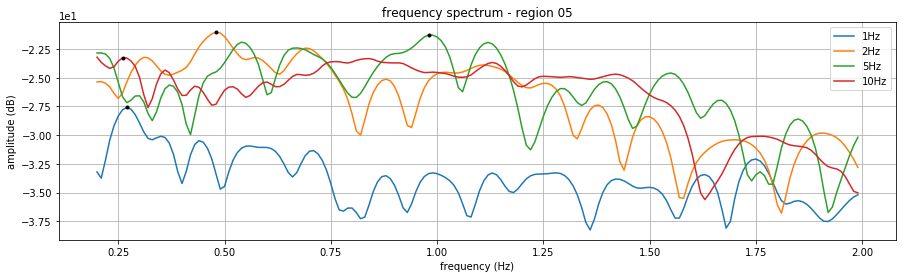

dominant frequencies:  ['0.27Hz', '0.48Hz', '0.98Hz', '0.26Hz']


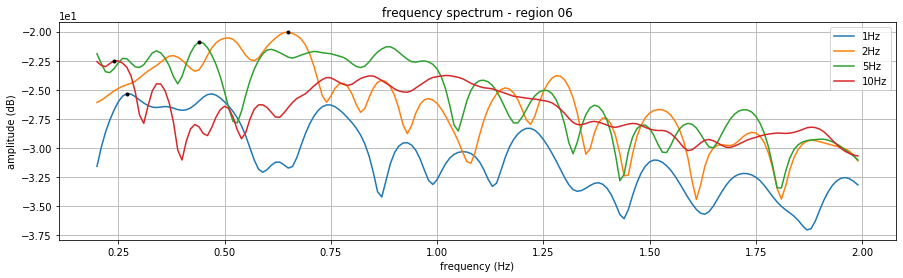

dominant frequencies:  ['0.27Hz', '0.65Hz', '0.44Hz', '0.24Hz']


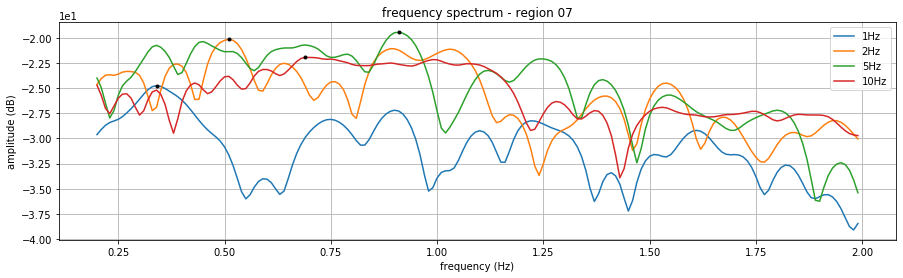

dominant frequencies:  ['0.34Hz', '0.51Hz', '0.91Hz', '0.69Hz']


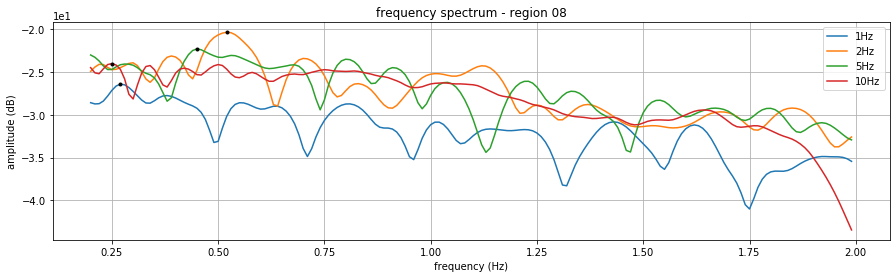

dominant frequencies:  ['0.27Hz', '0.52Hz', '0.45Hz', '0.25Hz']


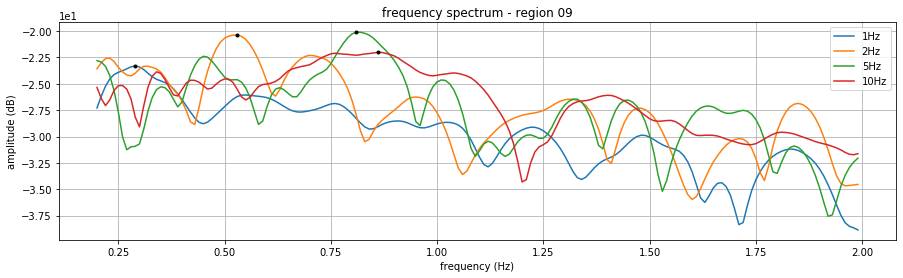

dominant frequencies:  ['0.29Hz', '0.53Hz', '0.81Hz', '0.86Hz']


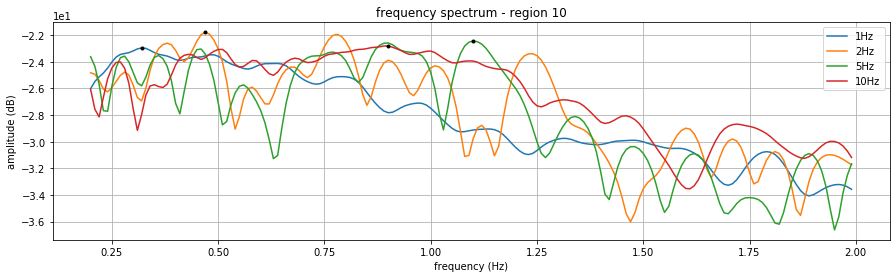

dominant frequencies:  ['0.32Hz', '0.47Hz', '1.1Hz', '0.9Hz']


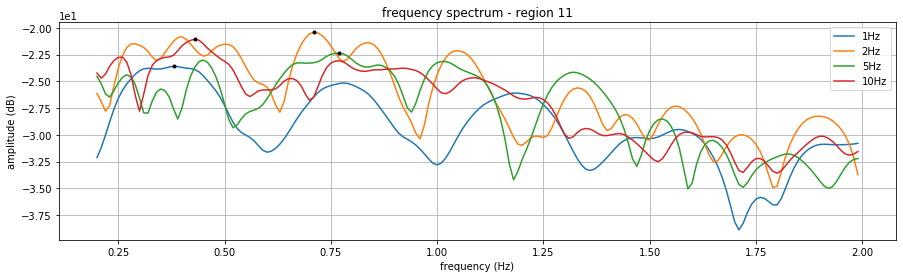

dominant frequencies:  ['0.38Hz', '0.71Hz', '0.77Hz', '0.43Hz']


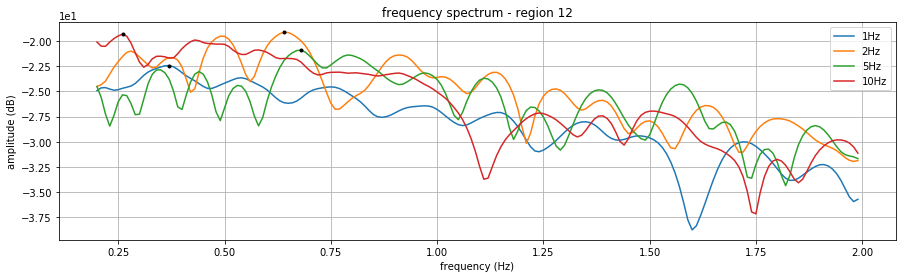

dominant frequencies:  ['0.37Hz', '0.64Hz', '0.68Hz', '0.26Hz']


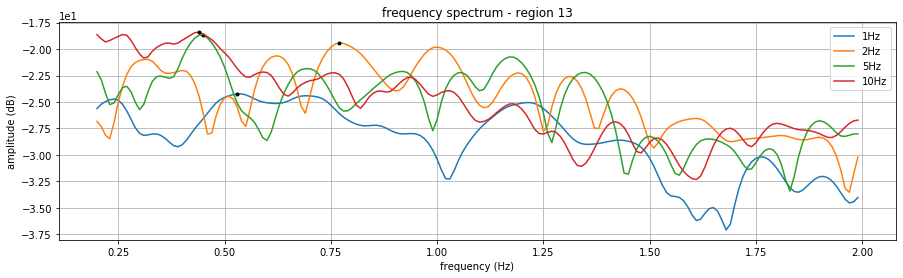

dominant frequencies:  ['0.53Hz', '0.77Hz', '0.45Hz', '0.44Hz']


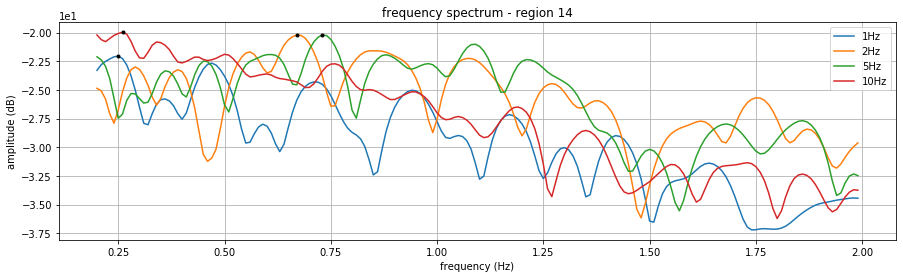

dominant frequencies:  ['0.25Hz', '0.67Hz', '0.73Hz', '0.26Hz']


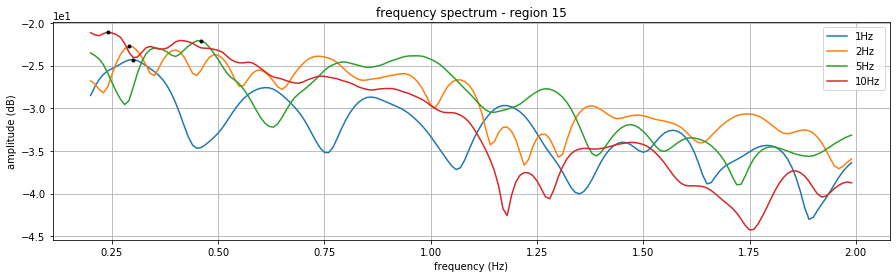

dominant frequencies:  ['0.3Hz', '0.29Hz', '0.46Hz', '0.24Hz']


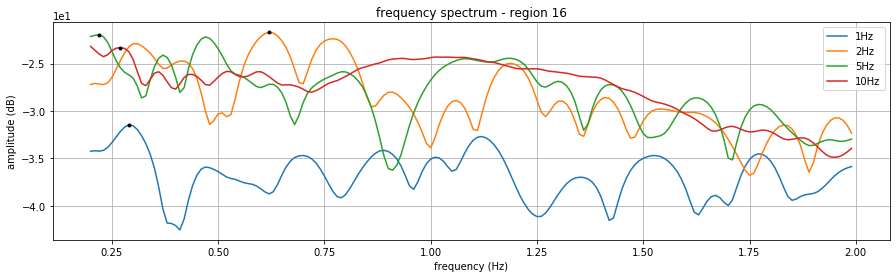

dominant frequencies:  ['0.29Hz', '0.62Hz', '0.22Hz', '0.27Hz']


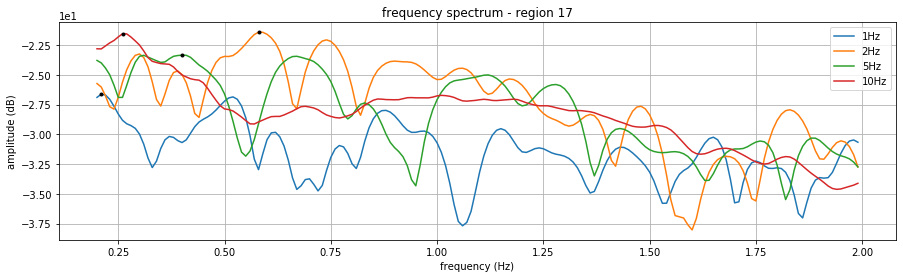

dominant frequencies:  ['0.21Hz', '0.58Hz', '0.4Hz', '0.26Hz']


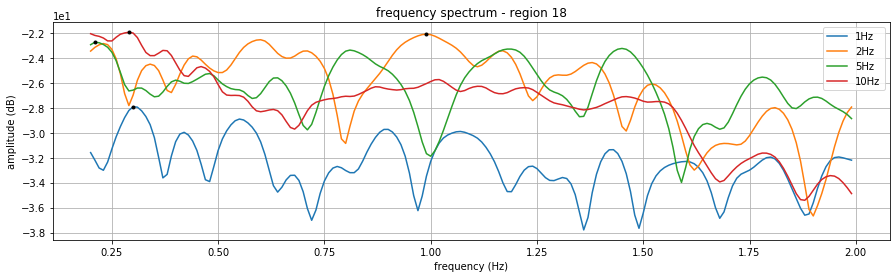

dominant frequencies:  ['0.3Hz', '0.99Hz', '0.21Hz', '0.29Hz']


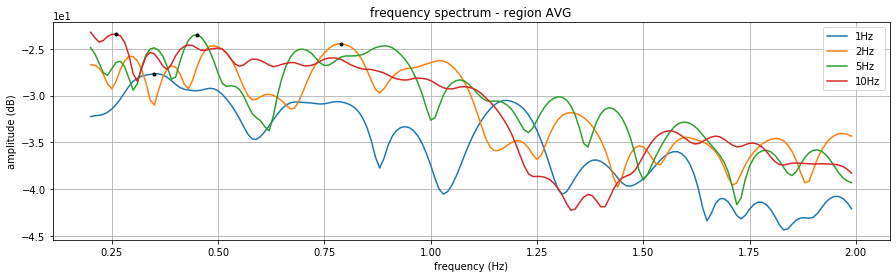

dominant frequencies:  ['0.35Hz', '0.79Hz', '0.45Hz', '0.26Hz']


In [3]:
%matplotlib inline

# get the regions and data labels in the selected results directory 
region_files = os.listdir("../results/" + results_widget.value)
region_files = sorted([f for f in region_files if 'apical_region' in f and '.csv' in f])
with open("../results/" + results_widget.value + "/labels.txt") as f:
  data_labels = f.readlines()
data_labels = [x.strip() for x in data_labels] 

sr = 50   # a new sample rate (for interpolation)
for r in region_files:
  region = r.split('_')[-1].split('-')[0]
  A0 = np.transpose(np.genfromtxt("../results/" + results_sel + "/" + r, delimiter=','))
  A = A0[:,stim_start:stim_done]

  tmin = np.min(A[0])
  tmax = np.max(A[0])
  trng = tmax-tmin
  tstp = A0[0,1]-A0[0,0]

  dmin = np.min(A[1:])
  dmax = np.max(A[1:])
  drng = dmax-dmin

  X0 = A[0]
  Y0 = (A[1:]-dmin) / drng  # normalized to range(0, 1.0)

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [15,4])
  ax.grid(b=True)

  fq = []  # list of the dominant frequencies
  for idx,y in enumerate(Y0):
    f = interp1d(X0, y, kind='cubic')                       # define the resampling function
    X = np.linspace(tmin, tmax, (trng*sr)+1, endpoint=True) # define the new time steps
    Y = f(X)                                                # resample the original signal
    sos = signal.butter(5, 0.2, btype='highpass', fs=sr, output='sos')
    Y = signal.sosfiltfilt(sos, Y)         # apply high-pass filter to eliminate step

    # use a filter bank for selective frequency response determination
    #wdw = signal.tukey(len(Y), alpha=0.3)      # define a windowing function
    fX = np.arange(0.2, 2.0, 0.01)             # filter bank frequencies (min, max, step)
    fY = []                                    # filter bank responses (rms)
    for s in fX:
      #ofs = 1.0/20  # filter half-width as fraction of octave
      #sos = signal.butter(2, ((2**(-ofs))*s,(2**ofs)*s), btype='bandpass', fs=sr, output='sos')
      sos = signal.butter(1, (s-0.01,s+0.01), btype='bandpass', fs=sr, output='sos')
      #Y1 = wdw*signal.sosfiltfilt(sos, Y)          # filter the signal and window the result
      Y1 = signal.sosfiltfilt(sos, Y)          # filter the signal
      fY.append(np.sqrt(np.mean(Y1**2)))       # save the rms value of the filtered signal
    ax.plot(fX,10*np.log10(fY),label=str(data_labels[idx]))

    _,pks = signal.find_peaks(fY,height=0)        # find peaks
    didx = fY.index(np.max(pks["peak_heights"]))  # get index of dominant frequency
    fq.append("{:3.3}Hz".format(fX[didx]))
    ax.plot(fX[didx],10*np.log10(fY[didx]),'k.')
  ax.legend()
  ax.set_title("frequency spectrum - region " + region)
  ax.set(ylabel="amplitude (dB)")
  ax.set(xlabel="frequency (Hz)")
  ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

  plt.show()
  plt.close() # frees up memory
  print("dominant frequencies: ", fq)


#### DIAGNOSTIC: Display the analysis portion of the first region data.

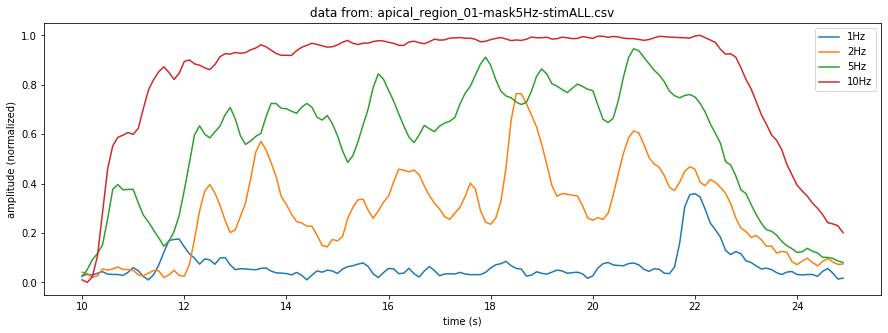

In [16]:
%matplotlib inline

rgn = 1
idx = 2  # index of trace to analyze

A0 = np.transpose(np.genfromtxt("../results/" + results_sel + "/" + region_files[rgn-1], delimiter=','))
A = A0[:,stim_start:stim_done]

tmin = np.min(A[0])
tmax = np.max(A[0])
trng = tmax-tmin
tstp = A0[0,1]-A0[0,0]

dmin = np.min(A[1:])
dmax = np.max(A[1:])
drng = dmax-dmin

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [15,5])
X0 = A[0]
Y0 = (A[1:]-dmin) / drng  # normalized to range(0, 1.0)
ax.plot(X0,np.transpose(Y0))

ax.set_title("data from: " + region_files[rgn-1])
ax.legend(data_labels)
ax.set(ylabel="amplitude (normalized)")
ax.set(xlabel="time (s)")

plt.show()
plt.close() # frees up memory


#### DIAGNOSTIC: Frequency analysis detail for one trace in the first region.


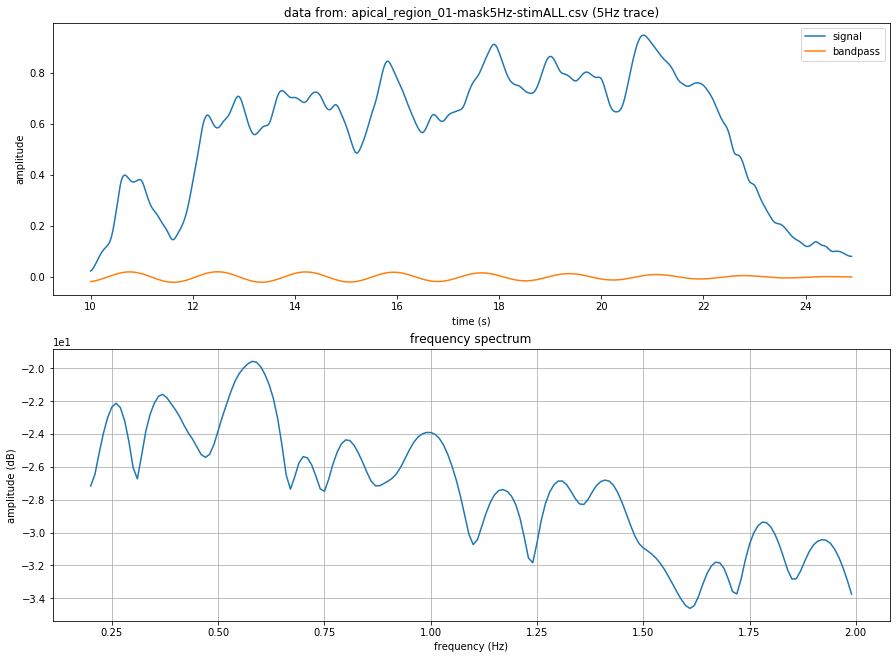

dominant frequency: 0.58Hz


In [17]:
%matplotlib inline

# upsample the data
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = [15,11])
             
sr = 50                                                 # a new sample rate (for interpolation)
f = interp1d(X0, Y0[idx], kind='cubic')                 # define the resampling function
X = np.linspace(tmin, tmax, (trng*sr)+1, endpoint=True) # define the new time steps
Y = f(X)                                                # resample the original signal
ax[0].plot(X,Y,label="signal")                          # plot the signal
sos = signal.butter(5, 0.2, btype='highpass', fs=sr, output='sos')
Y = signal.sosfiltfilt(sos, Y)         # apply high-pass filter to eliminate step

# use a filter bank for selective frequency response determination
fX = np.arange(0.2, 2.0, 0.01)             # filter bank frequencies (min, max, step)
fY = []                                    # filter bank responses (rms)
Ya = []                                    # list of all the filtered signals
for s in fX:
  #ofs = 1.0/20        # filter half-width as fraction of octave
  #sos = signal.butter(1, ((2**(-ofs))*s,(2**ofs)*s), btype='bandpass', fs=sr, output='sos')
  sos = signal.butter(1, (s-0.01,s+0.01), btype='bandpass', fs=sr, output='sos')
  Y1 = signal.sosfiltfilt(sos, Y)      # filter the signal
  Ya.append(Y1)                            # save a copy of the filtered signal
  fY.append(np.sqrt(np.mean(Y1**2)))       # save the rms value of the filtered signal

ax[1].plot(fX,10*np.log10(fY))    # plot the frequency response
ax[1].grid(b=True)

_,pks = signal.find_peaks(fY,height=0)         # find peaks
didx = fY.index(np.max(pks["peak_heights"]))   # get index of dominant frequency
ax[0].plot(X,Ya[didx],label="bandpass")  # plot the signal filtered by the dominant frequency

ax[0].set_title("data from: " + region_files[rgn-1] + " (" + data_labels[idx] + " trace)")
ax[0].legend()
ax[0].set(ylabel="amplitude")
ax[0].set(xlabel="time (s)")

ax[1].set_title("frequency spectrum")
ax[1].set(ylabel="amplitude (dB)")
ax[1].set(xlabel="frequency (Hz)")
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.show()
plt.close() # frees up memory
print("dominant frequency:", "{:3.3}Hz".format(fX[didx]))


#### DIAGNOSTIC: FFT vs filter bank frequency analysis

samples: 1024


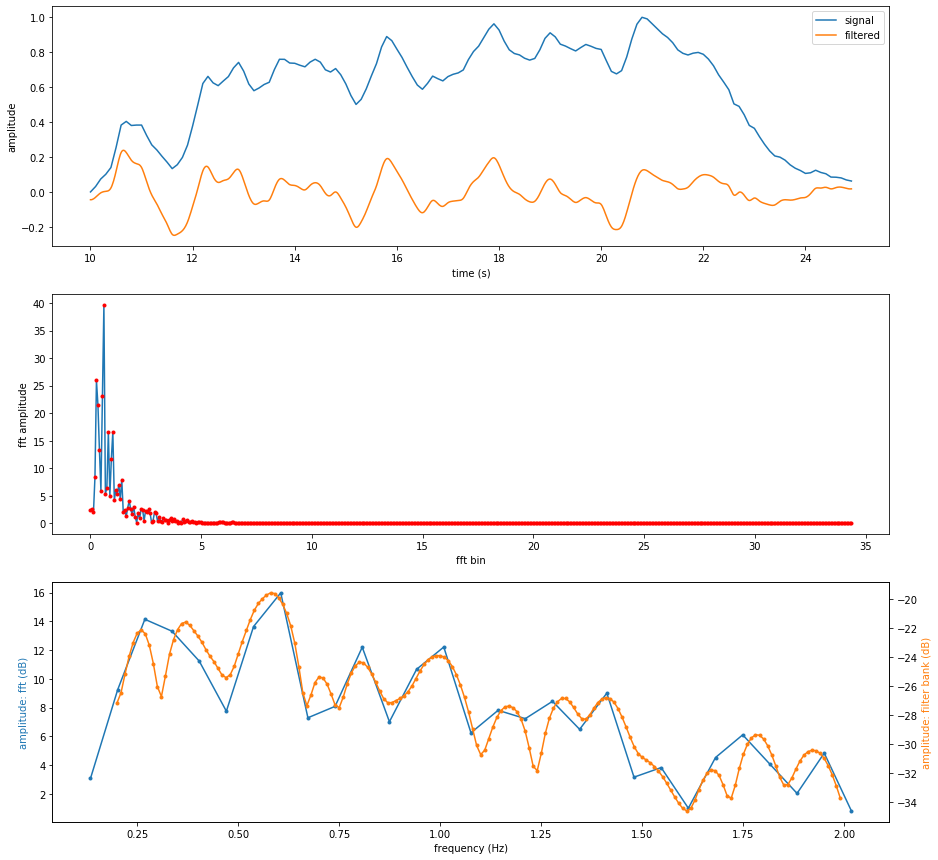

In [18]:
%matplotlib inline

fig, ax = plt.subplots(nrows=3, ncols=1, figsize = [15, 15])

# read in the data
A0 = np.transpose(np.genfromtxt("../results/" + results_sel + "/" + region_files[rgn-1], delimiter=','))
A = A0[idx+1,stim_start:stim_done]
dmin = np.min(A)
dmax = np.max(A)
drng = dmax-dmin

# normalize the data
X0 = A0[0,stim_start:stim_done]
Y0 = (A-dmin) / drng  # normalized to range(0, 1.0)
ax[0].plot(X0,Y0,label="signal")

# resample the data fot the fft
n = 10
p = 2**n
print("samples:", p)
f = interp1d(X0, Y0, kind='cubic')
X = np.linspace(tmin, tmax, p, endpoint=True)

Y = f(X)
sos = signal.butter(5, 0.2, btype='highpass', fs=p/trng, output='sos')
Yf = signal.sosfiltfilt(sos, Y)
ax[0].plot(X,Yf,label="filtered")
ax[0].legend()
ax[0].set(ylabel="amplitude")
ax[0].set(xlabel="time (s)")

# the FFT itself
sig = Yf
N = len(sig)
sr = p / trng
T = 1.0 / sr

Xfft = np.linspace(0.0, 1.0/(2.0*T), N//2)
Yfft = fft(sig, p)           # not using window

ax[1].plot(Xfft, np.abs(Yfft[:N//2]))
ax[1].plot(Xfft, np.abs(Yfft[:N//2]), 'r.')
ax[1].set(ylabel="fft amplitude")
ax[1].set(xlabel="fft bin")

axT = ax[2].twinx()
axT.plot(fX,10*np.log10(fY),'C1')    # plot the frequency response (scaled)
axT.plot(fX,10*np.log10(fY),'C1.')    # plot the frequency response (scaled)
axT.set_ylabel("amplitude: filter bank (dB)",color='C1')


s = 2
f = 31
ax[2].plot(Xfft[s:f], 10*np.log10(np.abs(Yfft[:N//2]))[s:f],'C0',label="fft")
ax[2].plot(Xfft[s:f], 10*np.log10(np.abs(Yfft[:N//2]))[s:f], 'C0.')
ax[2].set_ylabel("amplitude: fft (dB)",color='C0')
ax[2].set(xlabel="frequency (Hz)")

plt.show()
plt.close() # frees up memory
